In [34]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import xgboost as xgb
import pickle
from mpl import cross_valid
from sklearn import metrics
from sklearn import model_selection


In [2]:
# Load the data
itch_dt = pd.read_csv('data/ericson_data.csv')
itch_dt = itch_dt.rename(columns={"Subject":"person_id",
                        "Condition":"condition",
                        "Question":"question_id",
                        "X1":"ss_x",
                        "T1":"ss_t",
                        "X2":"ll_x",
                        "T2":"ll_t",
                        "LaterOptionChosen": "choice"}).drop(['R','G','D'],axis=1)

dataset = cross_valid.generate_sample(itch_dt)

# Define features and label
features = ['ss_x', 'ss_t', 'll_x', 'll_t',
            'abs_diff_x', 'abs_diff_t', 'rel_diff_x','rel_diff_t','growth_x']
label = 'choice'
X = dataset[features]
y = dataset[label]

# Split the data into train sample and test sample 
# Train sample containts 80% of the participants, test sample contains the rest 
groups = dataset['person_id']
train_index,test_index = list(model_selection.GroupShuffleSplit(n_splits=1,train_size=.8,random_state=2023).
                              split(X,y,groups))[0]
train_sample = dataset[dataset.index.isin(train_index)]
test_sample = dataset[dataset.index.isin(test_index)]

# Split the train sample into K folds (K=10) for cross-validation
sgkf = model_selection.StratifiedGroupKFold(n_splits=10,shuffle=True,random_state=2023)
cv = list(sgkf.split(X=train_sample[features],
                y=train_sample[label],
                groups=train_sample['person_id']))

In [7]:
len(set(dataset['person_id']))

939

In [17]:
# Use XGBoost to fit the data
# Tune the hyer-parameters by grid search 
param_grid = {'n_estimators': [40],
              'max_depth': [3],
              'learning_rate': [.1],
              'gamma': [.3],
              'reg_lambda': [.7],
              'subsample': [.55],
              'colsample_bytree': [1.0]
            }

model = xgb.XGBClassifier(objective='binary:logistic')

grid_search = model_selection.GridSearchCV(model, param_grid, cv=cv, 
                                           scoring=["accuracy","neg_log_loss",'neg_mean_absolute_error','neg_mean_squared_error'], 
                                           refit="neg_log_loss",
                                           n_jobs=-1,verbose=3)

grid_search.fit(X=train_sample[features], 
                y=train_sample[label], 
                groups=train_sample['person_id'])

# model = xgb.XGBClassifier(objective='binary:logistic',
#                           max_depth=3,
#                           learning_rate=.1,
#                           gamma=.3,
#                           reg_lambda=.7,
#                           subsample=.6,
#                           colsample_bytree=1.0,
#                           eval_metric=['error','logloss'],
#                           early_stopping_rounds=30)
# eval_set = [(X_train, y_train), (X_test, y_test)]
# bst = model.fit(X=X_train,
#                 y=y_train,
#                 eval_set=eval_set,
#                 verbose=True)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=[(array([    0,     1,     2, ..., 18182, 18183, 18184]),
                  array([   50,    51,    52, ..., 18085, 18086, 18087])),
                 (array([    0,     1,     2, ..., 18182, 18183, 18184]),
                  array([  167,   168,   169, ..., 17828, 17829, 17830])),
                 (array([    0,     1,     2, ..., 18182, 18183, 18184]),
                  array([  192,   193,   194, ..., 18127, 18128, 18129])),
                 (array([    0,     1,     2, ..., 18182, 18183, 18184]),
                  array([   74,    75,    76, ..., 17729, 17730, 17731])),
                 (array([    0,     1...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [1.0], 'gamma': [0.3],
                         'learning_rate': [0.1], 'max_depth': [3],
                         'n_estimators': [40], 'reg_lambda': [0.7],
                         'subsample': [0.55]},
             refit='neg_log_loss',
             scoring=['accuracy', 'neg_log_loss', 'neg_mean_absolute_error',
                      'neg_mean_squared_error'],
             verbose=3)

Best parameters: {'colsample_bytree': 1.0, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 40, 'reg_lambda': 0.7, 'subsample': 0.55}
{'dstyle': 'gbdt', 'ustyle': 'gbdt', 'params': None, 'accuracy': 0.7011608722299743, 'log_loss': 0.5811911011008668, 'mse': 0.2988391277700258, 'mae': 0.2988391277700258}


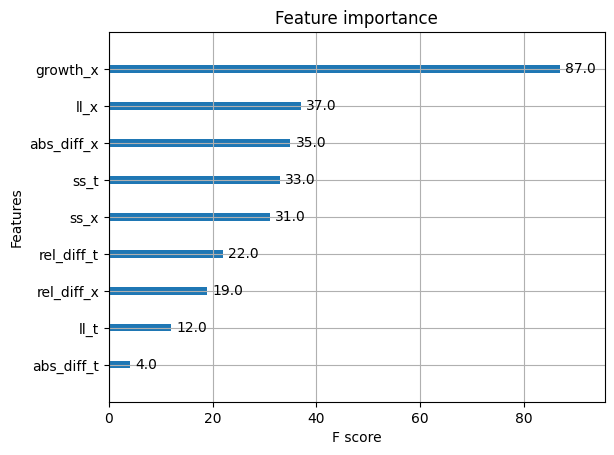

In [36]:
# Save the XGBoost model and check the feature importance
gbdt_result = {'dstyle': 'gbdt',
            'ustyle': 'gbdt',
            'params': None,
            'accuracy': grid_search.cv_results_['mean_test_accuracy'][0],
            'log_loss': -grid_search.cv_results_['mean_test_neg_log_loss'][0],
            'mse':-grid_search.cv_results_['mean_test_neg_mean_squared_error'][0],
            'mae':-grid_search.cv_results_['mean_test_neg_mean_absolute_error'][0]
            }

print(f"Best parameters: {grid_search.best_params_}")
print(gbdt_result)

bst_model = grid_search.best_estimator_
xgb.plot_importance(bst_model)
with open('my_model.pkl', 'wb') as f:
    pickle.dump(bst_model, f)

In [ ]:
# Plot a decision tree
# Change num_trees from 0 to 39, check different trees
xgb.to_graphviz(bst_model, num_trees=1)

In [40]:
# The out-of-sample performance of XGBoost model
with open('my_model.pkl', 'rb') as f:
    heuristic_model = pickle.load(f)

preds = heuristic_model.predict(test_sample[features])
trues = test_sample[label]

pred_binary = (preds > .5)

test_heuristic_dict = {'mse': metrics.mean_squared_error(trues, preds),
                       'mae': metrics.mean_absolute_error(trues, preds),
                       'log_loss': metrics.log_loss(trues, preds),
                       'accuracy': metrics.accuracy_score(trues, pred_binary),
                       'pred_ll':sum(pred_binary)/len(pred_binary)
                       }
test_heuristic_dict

{'mse': 0.29965080750763856,
 'mae': 0.29965080750763856,
 'log_loss': 10.800509843574387,
 'accuracy': 0.7003491924923614,
 'pred_ll': 0.26473155827149714}

In [41]:
# Fit data by distounted utility model and trade-off model
dstyle_list = list(cross_valid.estimation.config_param['discount_func'].keys())
ustyle_list = list(cross_valid.estimation.config_param['utility_func'].keys())
style_list = [{"dstyle":dstyle_list[i],
               "ustyle":ustyle_list[j],
               "method":'logit',
               "intercept":False} 
              for i in range(len(dstyle_list)) for j in range(len(ustyle_list))]

kf = cross_valid.KFvalidation(style=style_list,data=train_sample,cv=cv,n_jobs=4)
kf.fit()

100%|██████████| 220/220 [42:35<00:00, 11.61s/it]


In [43]:
# Compare models: Cross-validation result
kf_result_df = kf.summary()
kf_result_df['dstyle'] = kf_result_df['style'].apply(lambda x:x['dstyle'])
kf_result_df['ustyle'] = kf_result_df['style'].apply(lambda x:x['ustyle'])
df_cols = kf_result_df.columns.tolist()
df_cols = df_cols[-2:] + df_cols[:-2]
kf_result = kf_result_df.reindex(columns=df_cols).drop('style',axis=1)
kf_result = pd.concat([kf_result,pd.DataFrame(gbdt_result,index=[99])]).sort_values('log_loss')
kf_result

,dstyle,ustyle,params,mse,mae,log_loss,accuracy,pred_ll
99,gbdt,gbdt,None,0.298839,0.298839,0.581191,0.701161,NaN
21,trade,power,"[0.773, 1.128, 6.401, 0.409, 0.092, 0.079]",0.201905,0.403546,0.591444,0.694859,0.228946
13,hbmd,power,"[6.751, 0.149, 0.182]",0.204222,0.409320,0.597593,0.694343,0.228360
19,quasihb_fc,power,"[0.996, 0.997, 0.904, 0.009, 0.007]",0.207360,0.415097,0.603642,0.688867,0.239352
17,quasihb,power,"[0.997, 0.997, 0.007, 0.005]",0.207397,0.414831,0.603718,0.688867,0.239352
7,expo2,power,"[0.913, 0.752, 0.646, 0.01, 0.008]",0.207383,0.415668,0.603775,0.685805,0.244356
3,attention_uni,power,"[1.298, 0.176, 0.326]",0.208835,0.418370,0.607155,0.683527,0.152511
11,hb2,power,"[0.152, 2.614, 0.015, 0.013]",0.209411,0.418613,0.608559,0.684611,0.249073
9,hb,power,"[0.012, 0.027, 0.024]",0.209737,0.419905,0.609231,0.683284,0.251767
15,hce,power,"[0.993, 2.117, 0.01, 0.013]",0.210006,0.420338,0.609677,0.683284,0.251767


In [47]:
# Compare models: Out-of-sample performance
test_result = []

for i in range(len(kf_result_df)):

    test_style = kf_result_df['style'][i]
    test_params = kf_result_df['params'][i]

    test_scores = cross_valid.test_model(test_sample=test_sample,style=test_style,params=test_params)
    test_scores['dstyle'] = test_style['dstyle'] 
    test_scores['ustyle'] = test_style['ustyle']
    test_result.append(test_scores)

test_result = pd.DataFrame(test_result)
test_result = test_result.reindex(columns=df_cols).sort_values('log_loss').drop(['style','params'],axis=1)

test_heuristic_dict['dstyle'] = 'gbdt'
test_heuristic_dict['ustyle'] = 'gbdt'

test_result = pd.concat([test_result,pd.DataFrame(test_heuristic_dict,index=[99])]).sort_values('accuracy',ascending=False)
test_result

,dstyle,ustyle,mse,mae,log_loss,accuracy,pred_ll
13,hbmd,power,0.204391,0.407377,0.598332,0.700786,0.213226
99,gbdt,gbdt,0.299651,0.299651,10.800510,0.700349,0.264732
21,trade,power,0.202046,0.402179,0.591884,0.697730,0.210607
9,hb,power,0.208359,0.418450,0.606683,0.690310,0.245089
19,quasihb_fc,power,0.206735,0.416692,0.602913,0.689873,0.283937
17,quasihb,power,0.209022,0.400055,0.610947,0.689655,0.205587
5,expo,power,0.208985,0.415752,0.608228,0.681362,0.205587
15,hce,power,0.209189,0.416087,0.608668,0.681362,0.205587
3,attention_uni,power,0.210806,0.419025,0.611358,0.679834,0.149062
1,attention,power,0.215893,0.428781,0.624156,0.668485,0.124618


In [50]:
# Randomly draw 1000 questions from the dataset 
# Use the prediction value by XGBoost as the label
# Examine which model can explain the XGBoost's prediction the best
rda_sample = itch_dt[itch_dt.index.isin(np.random.choice(itch_dt.index,size=1000,replace=False))][['ss_x','ss_t','ll_x','ll_t']]
rda_sample = cross_valid.generate_sample(rda_sample)
rda_sample['choice'] = heuristic_model.predict(rda_sample[features])

rda_result = []

for i in range(len(kf_result_df)):

    rda_style = kf_result_df['style'][i]
    rda_params = kf_result_df['params'][i]

    rda_scores = cross_valid.test_model(test_sample=rda_sample,style=rda_style,params=rda_params)
    rda_scores['dstyle'] = rda_style['dstyle'] 
    rda_scores['ustyle'] = rda_style['ustyle']
    rda_result.append(rda_scores)

rda_result = pd.DataFrame(rda_result)
rda_result = rda_result.reindex(columns=df_cols).sort_values('accuracy',ascending=False).drop(['style','params'],axis=1)
rda_result

,dstyle,ustyle,mse,mae,log_loss,accuracy,pred_ll
21,trade,power,0.116259,0.319982,0.402297,0.905,0.238
13,hbmd,power,0.123578,0.330407,0.418045,0.896,0.239
19,quasihb_fc,power,0.136944,0.349498,0.449562,0.880,0.321
17,quasihb,power,0.124530,0.320258,0.414451,0.877,0.230
9,hb,power,0.145127,0.358655,0.467321,0.860,0.283
3,attention_uni,power,0.141021,0.351220,0.455357,0.853,0.174
5,expo,power,0.143615,0.354174,0.462649,0.842,0.239
15,hce,power,0.144140,0.354858,0.463764,0.842,0.239
1,attention,power,0.161015,0.375705,0.497726,0.833,0.150
20,trade,cara,0.159773,0.374307,0.500225,0.809,0.132


In [56]:
# Use the prediction value by magnitude-dependent hyperbolic (hbmd) with power utillity as the label
# Examine which model can explain the hbmd's prediction the best
ss_t = rda_sample['ss_t'].values
ss_x = rda_sample['ss_x'].values
ll_t = rda_sample['ll_t'].values
ll_x = rda_sample['ll_x'].values
kf_init_row = kf_result_df[(kf_result_df['dstyle']=='trade') & (kf_result_df['ustyle']=='power')]
init_style = kf_init_row['style'].values[0]
init_params = kf_init_row['params'].values[0]

rda_sample['init_choice'] = cross_valid.choice_rule.choice_prob(ss_x, ss_t, ll_x, ll_t, 
                                                            dstyle = init_style['dstyle'], 
                                                            ustyle = init_style['ustyle'], 
                                                            method = init_style['method'],
                                                            intercept= init_style['intercept'],
                                                            params = init_params[:-1], 
                                                            temper = init_params[-1]) 

rda_sample['choice'] = (rda_sample['init_choice']>.5)

rda_result = []

for i in range(len(kf_result_df)):

    rda_style = kf_result_df['style'][i]
    rda_params = kf_result_df['params'][i]

    rda_scores = cross_valid.test_model(test_sample=rda_sample,style=rda_style,params=rda_params)
    rda_scores['dstyle'] = rda_style['dstyle'] 
    rda_scores['ustyle'] = rda_style['ustyle']
    rda_result.append(rda_scores)

rda_result = pd.DataFrame(rda_result)
rda_result = rda_result.reindex(columns=df_cols).sort_values('accuracy',ascending=False).drop(['style','params'],axis=1)
rda_result.iloc[1:,:]


,dstyle,ustyle,mse,mae,log_loss,accuracy,pred_ll
13,hbmd,power,0.119289,0.326118,0.409297,0.945,0.239
17,quasihb,power,0.114866,0.310595,0.393456,0.920,0.230
9,hb,power,0.137929,0.351457,0.451721,0.897,0.283
3,attention_uni,power,0.136919,0.347119,0.447106,0.884,0.174
1,attention,power,0.152359,0.367049,0.479605,0.882,0.150
5,expo,power,0.134611,0.345170,0.443175,0.881,0.239
15,hce,power,0.134754,0.345473,0.443532,0.881,0.239
19,quasihb_fc,power,0.134172,0.346726,0.443693,0.875,0.321
20,trade,cara,0.147103,0.361636,0.473816,0.854,0.132
6,expo2,cara,0.187767,0.397876,0.560264,0.765,0.009


In [57]:
# Save the results
kf_result.to_csv("itch_result_kf.csv",index=False)
test_result.to_csv("itch_result_test.csv",index=False)
rda_result.to_csv("itch_result_rda.csv",index=False)

In [61]:
np.where(kf.success==False)


(array([], dtype=int64),)